In [162]:
import scipy
import tensorflow
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import random
import matplotlib.pyplot as plt
import pandas as pd

from PyEMD import EMD


In [6]:
X = np.random.randn(1000, 100, 1)  # Shape: (samples, time points, channels)
y = np.random.randint(0, 2, (1000,))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
# Fit on training set only
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# Apply transform to both the training set and the test set
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Users/toufikjrab/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_split=0.2)

_, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5367 - loss: 0.7680 - val_accuracy: 0.5625 - val_loss: 0.6914
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4973 - loss: 0.6875 - val_accuracy: 0.5625 - val_loss: 0.6898
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5240 - loss: 0.6829 - val_accuracy: 0.5625 - val_loss: 0.6908
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5438 - loss: 0.6711 - val_accuracy: 0.4437 - val_loss: 0.6976
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6458 - loss: 0.6631 - val_accuracy: 0.4812 - val_loss: 0.7001
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 0.6459 - val_accuracy: 0.5000 - val_loss: 0.7055
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6739 - loss: 0.6237 - val_accuracy: 0.4688 - val_loss: 0.7242
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6917 - loss: 0.6094 - val_accuracy: 0.4250 - val_loss:

In [115]:
# dataset_dir_control = "csv_averaged_force_data_4col/GaCo04_01.csv"
# dataset_dir_pd = "csv_averaged_force_data_4col/GaPt03_01.csv"

features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']
file = '/Users/toufikjrab/Projects/gait-in-parkinsons-disease-1.0.0/Ga_study/GaCo16_01.txt'
df = pd.read_csv(file, delim_whitespace=True, header=None)
df.columns = features


In [104]:
# Calcuating the FAV = |L_k - R_k|/L_k  x 100%
# FAV is the fluctuation amplitude variability defined as a criterion in the paper
data_directory_Ga = '/Users/toufikjrab/Projects/gait-in-parkinsons-disease-1.0.0/Ga_study'
data_directory_Ju = '/Users/toufikjrab/Projects/gait-in-parkinsons-disease-1.0.0/Ju_study'
data_directory_Si = '/Users/toufikjrab/Projects/gait-in-parkinsons-disease-1.0.0/Si_study'

# Defining a function that goes through the entire sensor column and finding the FAV
def calculate_fav(df):
    fav_values = {}

    for i in range(1, 9):
        L = df[f'VGRF_L{i}']
        R = df[f'VGRF_R{i}']
        # Filter out instances where L is near-zero to avoid distortion in FAV calculation
        valid_indices = L > 0.01  # or another threshold appropriate for your data
        L_valid = L[valid_indices]
        R_valid = R[valid_indices]
        
        if not L_valid.empty:  # Ensure there are valid data points for calculation
            fav = (abs(L_valid - R_valid) / L_valid).mean() * 100
            fav_values[i] = fav
        else:
            fav_values[i] = 0  # or set to 0 or other indicator value

    # Sort sensors by FAV in descending order, excluding None values
    sorted_fav = sorted(fav_values.items(), key=lambda item: item[1], reverse=True)
    
    top_sensors = sorted_fav[:4]
    return top_sensors

In [105]:
top_sensors = calculate_fav(df)
print("Top 4 sensors based on FAV:", top_sensors)

Top 4 sensors based on FAV: [(3, 466.51481087645755), (4, 465.821311188688), (5, 342.2022389375435), (7, 207.32299990740935)]


In [111]:
## Selecting the optimal sensors for each file and making a csv file 
all_fav_results = {}
data_files = [f for f in os.listdir(data_directory_Ju) if os.path.isfile(os.path.join(data_directory_Ju, f))]
features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']

file_error = []
for file_name in data_files:
    if file_name.startswith('.'):
        # Skip hidden files like .DS_Store
        continue
    
    file_path = os.path.join(data_directory_Ju, file_name)

    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, encoding_errors = 'ignore')
        df.columns = ['Time'] + [f'VGRF_L{i}' for i in range(1, 9)] + [f'VGRF_R{i}' for i in range(1, 9)] + ['Total_L', 'Total_R']

        top_sensors = calculate_fav(df)
        all_fav_results[file_name] = top_sensors
    except Exception as e:
        file_error.append(file_path)


In [112]:
print(file_error)

[]


In [113]:
# Assuming `fav_values` is a dictionary with your FAV data
fav_df = pd.DataFrame(list(all_fav_results.items()), columns=['File_name', 'Optimal 4 Sensor numbers to FAV Dictionary'])
fav_df.to_csv('fav_values_Ju.csv', index=False)

In [163]:
# Selected Sensors: 2, 4, 6, 8
file = '/Users/toufikjrab/Projects/gait-in-parkinsons-disease-1.0.0/Ga_study/GaCo16_01.txt'
df = pd.read_csv(file, delim_whitespace=True, header=None)
df.columns = features


def find_imfs(df):
    selected_sensors = [2,4,6,8]

    emd = EMD() 

    imfs_by_sensor = {} # dict to hold IMFs for each selected sensor

    for sensor_num in selected_sensors:
        # For left foot sensors
        sensor_name_L = f'VGRF_L{sensor_num}'
        signal_L = df[sensor_name_L].values
        imfs_L = emd(signal_L)
        imfs_by_sensor[sensor_name_L] = imfs_L

        # For right foot sensors
        sensor_name_R = f'VGRF_R{sensor_num}'
        signal_R = df[sensor_name_R].values
        imfs_R = emd(signal_R)
        imfs_by_sensor[sensor_name_R] = imfs_R
    
    return imfs_by_sensor

imfs_by_sensor = find_imfs(df)
# Power spectral analysis of the IMFs using scipy.signal
def calculate_psd(imfs):
    psd_dict = {}  
    fs = 100 # sampling frequency in Hz

    for i, imf in enumerate(imfs): # imfs being 2D array & each row an IMF
        f, Pxx_den = scipy.signal.periodogram(imf, fs)
        psd_dict[f'IMF{i+1}'] = (f, Pxx_den)

    return psd_dict


In [171]:
print(imfs_by_sensor)

{'VGRF_L2': array([[  0.05776688,  -0.53381375,   0.55004188, ...,   1.36599535,
          1.32240214,   1.2877278 ],
       [  5.08261978,   7.37248653,   5.3227489 , ...,   0.04764845,
          0.06246289,   0.06033766],
       [-18.64397151, -20.29506629, -17.46616461, ...,  -0.08752168,
         -0.08751137,  -0.06266475],
       ...,
       [  4.96207528,   4.96810165,   4.97404317, ...,   5.32405459,
          5.31180171,   5.29947623],
       [ -4.36268945,  -4.36479189,  -4.3669092 , ...,  -6.96563264,
         -6.96269764,  -6.95974033],
       [ 40.96184032,  40.9622181 ,  40.9625956 , ...,  32.9912037 ,
         32.99106589,  32.99092899]]), 'VGRF_R2': array([[-25.0759569 , -25.07741902, -12.62149231, ...,  -0.10982982,
         -0.05032539,   0.16793468],
       [ -6.64763706,  -9.78497825,  -8.36695628, ...,   0.10253752,
          0.10422819,   0.12147775],
       [ -2.4473505 ,  -3.82843372,  -3.82836439, ...,   1.48012865,
          1.122706  ,   0.27589636],
       ..

In [164]:
imfs_df = pd.DataFrame(list(imfs_by_sensor.items()), columns=['sensor_name', 'IMFs'])
imfs_df.to_csv('IMF_GaCo16_01.csv', index=False)

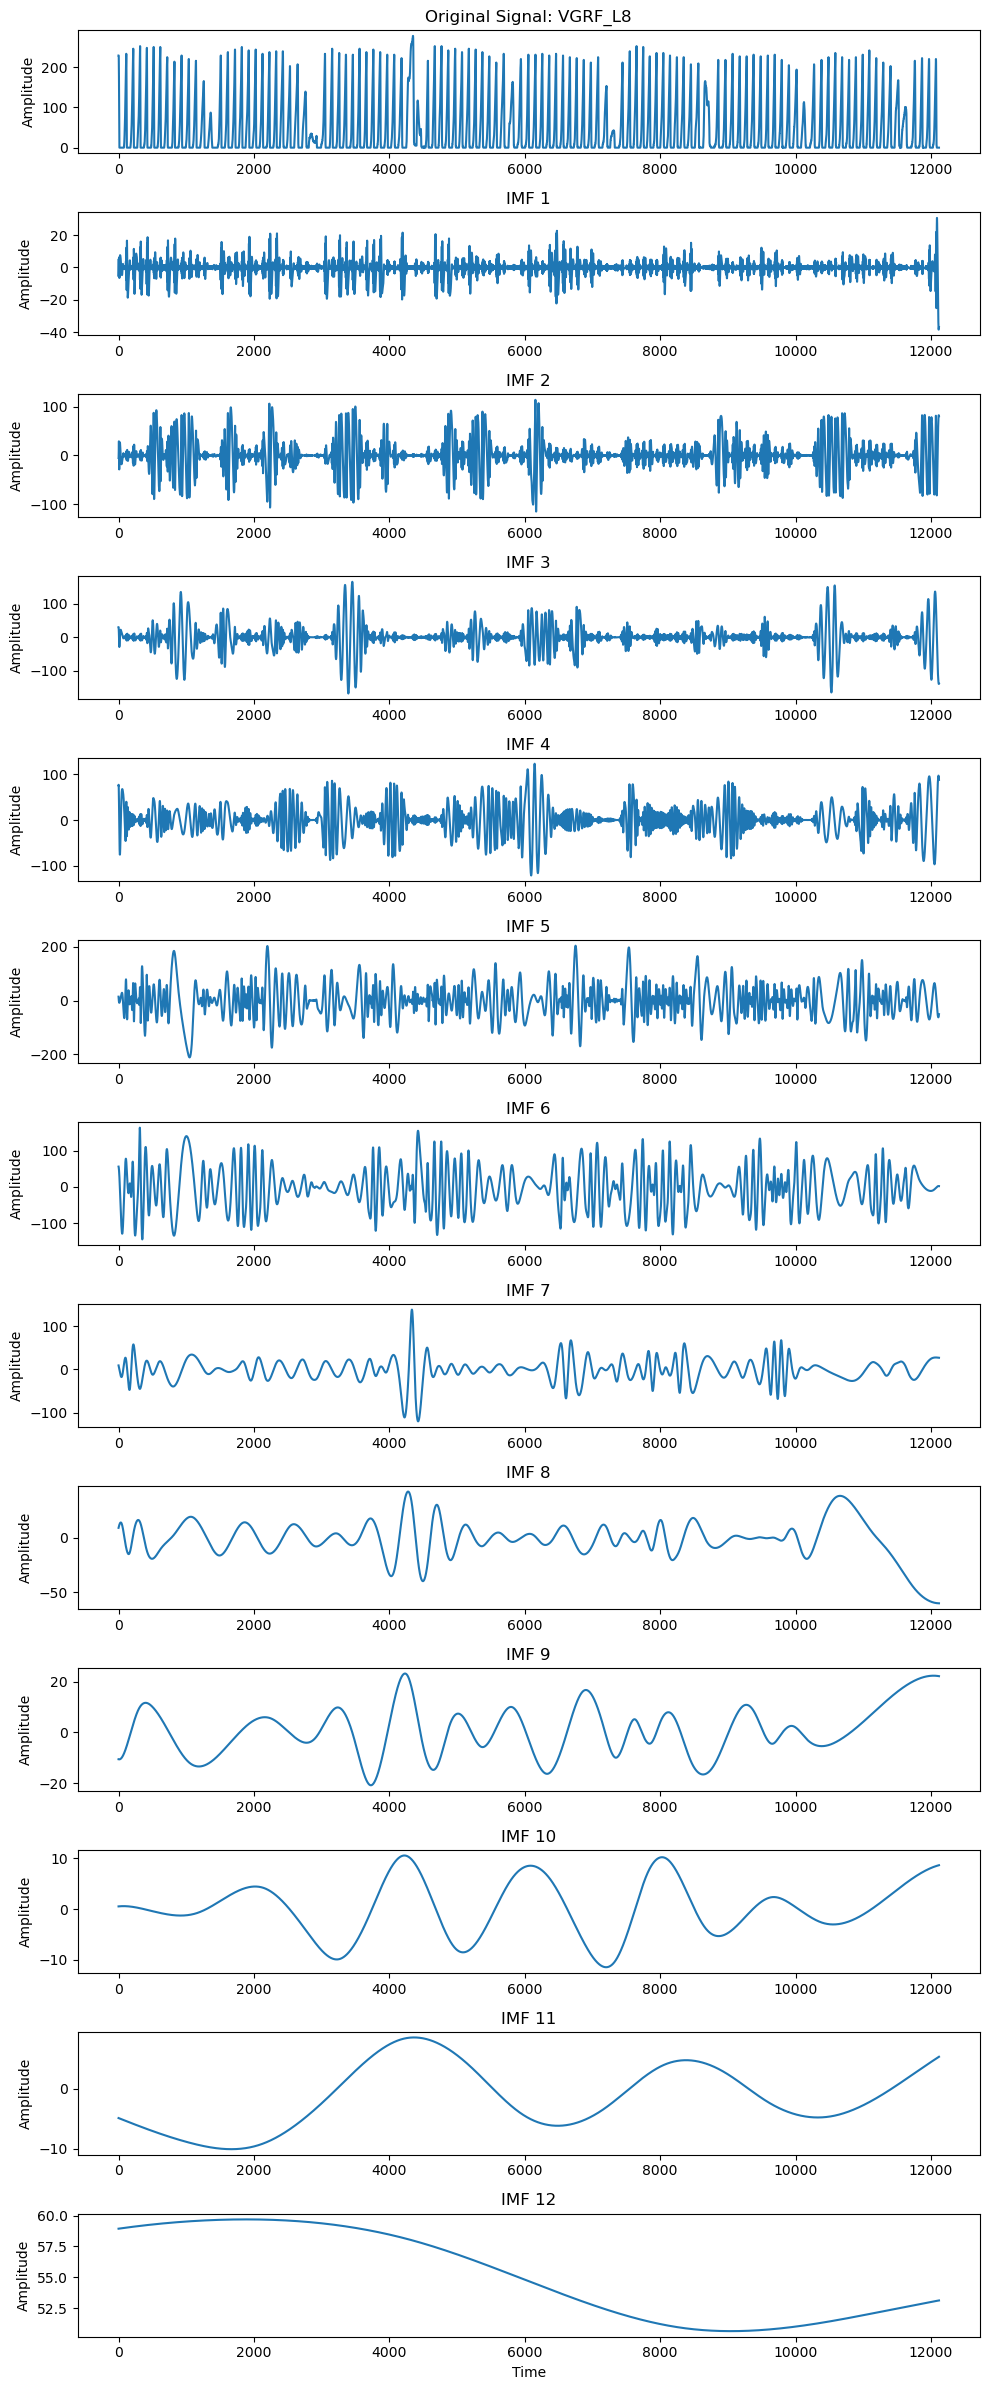

In [165]:
def plot_imfs(signal, imfs, sensor_name):
    """
    Plots the original signal and its corresponding IMFs.
    
    :param signal: The original signal (1D numpy array).
    :param imfs: The Intrinsic Mode Functions (2D numpy array where each row is an IMF).
    :param sensor_name: The name of the sensor (string) for titling the plot.
    """
    n_imfs = imfs.shape[0]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(n_imfs + 1, 1, figsize=(10, 2 * n_imfs))  # +1 for the original signal
    
    # Plot the original signal
    axs[0].plot(signal)
    axs[0].set_title(f'Original Signal: {sensor_name}')
    axs[0].set_ylabel('Amplitude')
    
    # Plot each IMF in a separate subplot
    for i in range(n_imfs):
        axs[i + 1].plot(imfs[i])
        axs[i + 1].set_title(f'IMF {i+1}')
        axs[i + 1].set_ylabel('Amplitude')
    
    # Set the xlabel for the last subplot
    axs[-1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

# Example usage for plotting the IMFs for a specific sensor (e.g., 'VGRF_L8')
sensor_name = 'VGRF_L8'
signal = df[sensor_name].values  # Make sure df and sensor_name are defined
imfs = imfs_by_sensor[sensor_name]  # Make sure imfs_by_sensor is defined and contains the IMFs

plot_imfs(signal, imfs, sensor_name)

In [166]:
# ploting function for psd_dict

def plot_psd_for_all_imfs(psd_dict):
    plt.figure(figsize=(10, 6))
    for imf, (freqs, pxx_den) in psd_dict.items():
        plt.plot(freqs, pxx_den, label=imf)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Power Spectral Density for Each IMF')
    plt.legend()
    plt.show()


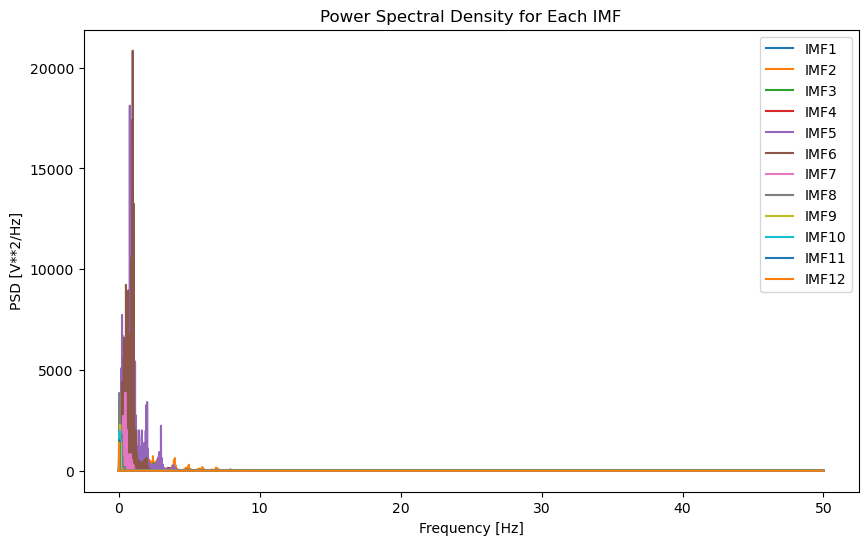

In [167]:
psd_dict = calculate_psd(imfs)
plot_psd_for_all_imfs(psd_dict)

In [168]:
# Extracting dominant IMFs using psd done

def find_dominant_imfs(psd_dict, N):
    total_power = {imf: np.sum(pxx_den) for imf, (f,pxx_den) in psd_dict.items()}

    sorted_imfs = sorted(total_power.items(), key=lambda x:x[1], reverse=True)
    # Select top N
    dominant_imfs = sorted_imfs[:N]

    return dict(dominant_imfs)

Dominant IMFs: {'IMF5': 458315.29574738524, 'IMF6': 372349.59954447404, 'IMF3': 161355.40140579807}


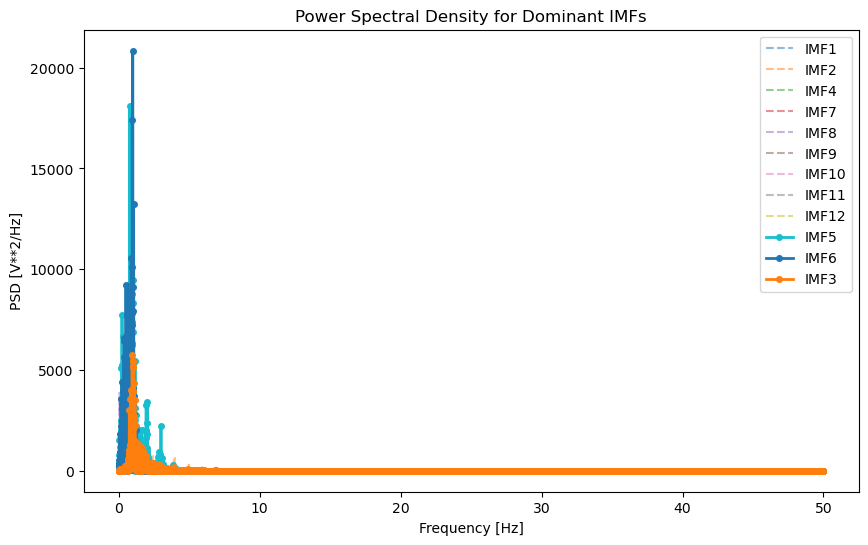

In [170]:
dominant_imfs = find_dominant_imfs(psd_dict,3)
# Ensure this returns the expected dominant IMFs
# dominant_imfs_keys = find_dominant_imfs(psd_dict, n=3)
print("Dominant IMFs:", dominant_imfs)

def plot_dominant_imfs(psd_dict, dominant_imfs_keys):
    plt.figure(figsize=(10, 6))
    
    for imf in psd_dict:
        if imf not in dominant_imfs_keys.keys():
            freqs, pxx_den = psd_dict[imf]
            plt.plot(freqs, pxx_den, linestyle='--', alpha=0.5, label=imf)
    
    # Now plot the dominant IMFs for clear visibility
    for imf in dominant_imfs_keys.keys():
        freqs, pxx_den = psd_dict[imf]
        plt.plot(freqs, pxx_den, linewidth=2, marker='o', markersize=4, label=imf)
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Power Spectral Density for Dominant IMFs')
    plt.legend()
    plt.show()

plot_dominant_imfs(psd_dict, dominant_imfs)

In [ ]:
# Function that iterates through entire data-set


In [ ]:
## Concatentation of Dominant IMFs into a matrix of shape (T, num_dominant_IMFs)
# Will be shape (110, 3) for each individual
# Aggregated data across entire study: shape (num_individuals, T, num_dominant_IMFs * num_sensors)
# (112, 110, 12) for Ga_study

num_individuals = 112 
# IMPORTANT: for now this includes 01, 02, and 10 conditions for the same individuals
# this could be detrimental but for getting a working model sake, will proceed

T = 110 # seconds
num_dominant_IMFs = 3
num_sensors = 4

data_shape_Ga = (num_individuals, T, num_dominant_IMFs * num_sensors)
data_shape_individual_Ga = (T, num_dominant_IMFs * num_sensors)

def process_individual_file(df,T, num_dominant_IMFs, num_sensors):
    """
    Pipeline function that iterates through the initial df of a given individual 
    to return the necessary analyzed structure:
    individual_matrix: np array of data_shape_individual shape
    contains an hstack of T, dominant_imfs_L, dominant_imfs_R
    """
    data_shape_individual = (T, num_dominant_IMFs * num_sensors) 
    individual_data = np.empty((T,0))
    selected_sensors = [2,4,6,8]

    for sensor_index in selected_sensors:
        sensor_name_L = f'VGRF_L{sensor_index}'
        sensor_name_R = f'VGRF_R{sensor_index}'

        imfs_L = find_imfs(df[sensor_name_L])
        imfs_R = find_imfs(df[sensor_name_R])

        psd_L = calculate_psd(imfs_L)
        psd_R = calculate_psd(imfs_R)
        dominant_imfs_L_dict = find_dominant_imfs(psd_L, num_dominant_IMFs)  # Assumes this returns indices or keys
        dominant_imfs_R_dict = find_dominant_imfs(psd_R, num_dominant_IMFs)

        for imf_L in dominant_imfs_L_dict.keys():
            
        dominant_imfs_L = imfs_L[:, dominant_imfs_L_dict]
        dominant_imfs_R = imfs_R[:, dominant_imfs_R_dict]

In [ ]:
# all_fav_results = {}
data_files = [f for f in os.listdir(data_directory_Ga) if os.path.isfile(os.path.join(data_directory_Ga, f))]
features = ['Time','VGRF_L1','VGRF_L2','VGRF_L3','VGRF_L4','VGRF_L5','VGRF_L6','VGRF_L7','VGRF_L8',
            'VGRF_R1','VGRF_R2','VGRF_R3','VGRF_R4','VGRF_R5','VGRF_R6','VGRF_R7','VGRF_R8','Total Force_L','Total Force_R']

file_error = []
for file_name in data_files:
    if file_name.startswith('.'):
        # Skip hidden files like .DS_Store
        continue
    
    file_path = os.path.join(data_directory_Ga, file_name)

    try:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None, encoding_errors = 'ignore')
        df.columns = features

        structured_data = process_individual_file(df)
        
        imfs_df = pd.DataFrame(list(dominant_imfs.items()), columns=['sensor_name', 'IMFs'])
        imfs_df.to_csv(f'{}.csv', index=False)
    except Exception as e:
        file_error.append(file_path)

In [146]:
## NOW ONTO ML TRAINING 

# Define model architecture - based on StackOverFlow
# Link: https://stackoverflow.com/questions/55433649/how-to-combine-lstm-and-cnn-models-in-keras

model = Sequential()

# Assuming each time series input has a shape of (sequence_length, num_dominant_imfs)
model.add(Conv1D(filters=64, kernel_size = 3, activation = 'relu',input_shape= (sequence_length, num_dominant_imfs)))
model.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.5))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten output from CNN layers before passing onto LSTM
model.add(Flatten())

model.add(Reshape((-1, 128)))
model.add(LSTM(100))
model.add(Dropout(0.5))

# Per the paper, they used softmax LSTM, Adam optimizer, and a cross_entropy loss function
model.add(Dense(num_classes, activation='softmax'))  # Assuming a classification task

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


IndentationError: unexpected indent (1846677755.py, line 34)

In [ ]:


merged = Concatenate()([model1.output,model2.output])
z = Dense(128, activation="relu")(merged)
z = Dropout(0.25)(z)
z = Dense(1024, activation="relu")(z)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[model1.input, model2.input], outputs=z)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


        model.fit([x_train[train_index][:,:66], x_train[train_index][:,66:132], y_train[train_index], batch_size=100, epochs=100, verbose=2)